# Electric Fixed Wing sUAS Design

### Introduction
The following will overview the design process for an electric fixed wing small unmanned aerial system (sUAS) as well as providing code for designing one. Due to the nature of the vehicle being designed, the operational conditions are assumed to be standard sea level. All units are SI unless otherwise noted.

Sources for data regarding electric aircraft and/or sUAS specifications listed below:

https://www.atmos.albany.edu/daes/atmclasses/env327/References/UAS-jtech-d-13-00236%252E1.pdf

https://www.pipistrel-aircraft.com/products/velis-electro/#1680717339675-b6d1143d-a61a1680811899143

In [78]:
# Setup

# Imports
import numpy as np
import matplotlib.pyplot as plt

# Constants
pi = 3.1415926
kg_to_lbm = 2.20462             # kilogram to pound-mass conversion
km_to_mi = 0.621371             # kilometer to mile conversion


# Physical Constants
gravity = 9.80665               # m/s^2

# Standard Sea Level Atmosphere
density = 1.225                 # kg/m^3
temp_C = 15                     # C
temp_K = 288.2                  # K
pressure = 101325               # Pa
speed_of_sound = 340.3          # m/s
dynamic_viscosity = 1.789e-5    # kg/m/s
kinematic_viscosity = 1.460e-5  # m^2/s
gas_constant = 287.1            # J/kg/K
temp_lapse_rate = 0.0065        # K/m
molar_mass = 0.0289652          # kg/mol
ratio_of_specific_heats = 1.4   # unitless

### Requirements

Any aircraft design process begins by defining requirements. These will likely be adjusted in an iterative process as certain combinations of requirements are mutually exclusive given a certain budget or current available technology.

In [79]:
# Requirements

W_payload = 0.5 * gravity  # N, required payload weight
range = 20000  # m, required range


### Initial Sizing Estimate

The first step of aircraft design is an estimate of gross takeoff weight given by the following formula

\begin{gathered}
W_0 = \frac{W_p}{1-\frac{W_b}{W_0}-\frac{W_e}{W_0}} 
\end{gathered}

Where

\begin{gathered}
W_0 = \text{Gross Takeoff Weight} \\
W_p = \text{Payload Weight (All Non-Flight-Critical Mass)} \\
\frac{W_b}{W_0} = \text{Battery Weight Fraction} \\
\frac{W_e}{W_0} = \text{Empty Weight Fraction} \\
\end{gathered}

Payload weight is a requirement. Battery Weight Fraction is estimated based on the mission requirements. Empty weight fraction is estimated based on the Gross Takeoff Weight. However, since Gross Takeoff Weight is what we are solving for, Empty Weight Fraction and Gross Takeoff Weight must be estimated iteratively.

Source: Raymer 6th Ed. Chapter 3

##### Battery Weight Fraction Estimate

Note that unlike standard fuel-based aircraft, electric aircraft use a constant-weight battery. The following method of estimating Battery Weight Fraction is used.

For a low altitude electric sUAS, I will assume climb and landing make up a relatively small portion of flight time and can therefore be treated identically to cruise. Therefore the Battery Weight Fraction can be estimated using only the Range, Estimated L/D and Estimated Powertrain Efficiency

\begin{gathered}
\frac{W_b}{W_0} = \frac{g*R}{3600*e*\frac{L}{D}*\eta}
\end{gathered}

where

\begin{gathered}
g = \text{gravity (m/s/s)} \\
R = \text{Range (m)} \\
e = \text {Battery Specific Energy (W*hr/kg)} \\
\frac{L}{D} = \text{Lift to Drag Ratio} \\
\eta = \text{Efficiency } (\eta_{propeller} * \eta_{motor} * \eta_{esc} * \eta_{battery} * \eta_{wire})
\end{gathered}


Source: Raymer 6th Ed. Chapter 20 Pg 759

Range is a Requirement and therefore does not require estimation.

Propeller efficiency is a function of advance ratio, but for initial sizing purposes we will assume it falls between 0.5 and 0.7.

See: https://m-selig.ae.illinois.edu/props/propDB.html

Wire efficiency is extremely high at such short lengths and is assumed to be 0.99. All other efficiencies are fairly high and have been roughly estimated as 0.9.

Specific Energy is estimated to be approximately 140 W*Hr/kg for RC Hobby-Grade LiPo Batteries. This can be higher or lower depending on battery quality.

See: https://www.rcgroups.com/forums/showthread.php?1767093-Battery-Load-Test-Comparisons

L/D Can be Estimated based on historical data from similar airplanes. An electric sUAS will likely have and L/D in the 5-15 range. For a physical intuition, L/D is equivalent to the unpowered glide slope of an airplane.

A method of L/D estimation is to use the formula

\begin{gathered}
\frac{L}{D}_{max} = K_{LD} * \sqrt{A_{wet}} \\

\text{where } K_{LD} = 9 \text{ for non-retractable gear, propeller aircraft} \\
A_{wet} = \frac{b^2}{S_{wet}} = \frac{A}{S_{wet}/S_{ref}} = \text{Wetted Aspect Ratio} \\
A = \frac{b^2}{S_{ref}} = \text{Aspect Ratio} \\
b = \text{Wing Span} \\
S_{wet} = \text{Wetted Area (Total Surface Area of the Airplane)} \\
S_{ref} = \text{Wing Area (Planform Area)} \\
\end{gathered}

Aspect Ratio is selected as part of the initial rough configuration. A traditional general aviation propeller-recip aircraft will have an aspect ratio between 5-8. For the purposed of an electric sUAS, I will assume


Wetted Area Ratio, S<sub>wet</sub>/S<sub>ref</sub>, can be estimated by "eyeballing" the configuration compared to historical data. See plot below: 

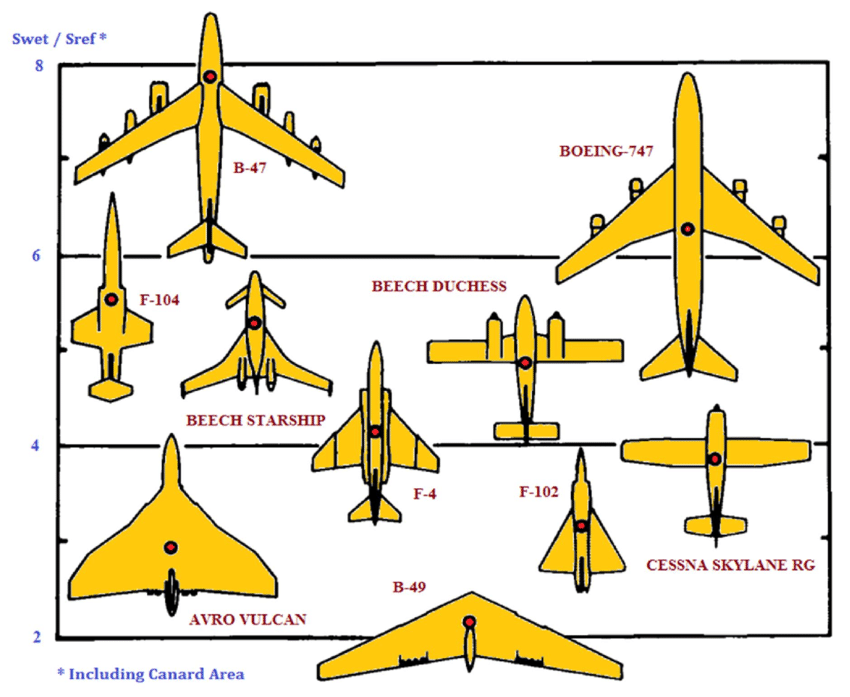

Source: Raymer 6th Ed. Chapter 3

In [80]:
# Inputs
efficiency_propeller = .6  # propeller efficiency
efficiency_wire = .99  # wire effiency
efficiency_motor = .9  # motor efficiency
efficiency_esc = .9  # esc efficiency
efficiency_batt = .9  # battery efficiency

batt_specific_energy = 140  # W*Hr/kg, RC Grade Lipo Specific Energy

#wingspan_estimate = 1  # m, initial estimate for wingspan
aspect_ratio_estimate = 6  # initial estimate for aspect ratio
wetted_area_ratio_estimate = 4  # initial estimate for wetted area ratio
k_LD = 9

# Outputs
print(f"Required Range: {range} m")

efficiency_total = efficiency_propeller * efficiency_motor * efficiency_esc * efficiency_batt * efficiency_wire
print(f"Total Efficiency: {efficiency_total:.3f}")

print(f"Battery Specific Energy: {batt_specific_energy} W*hr/kg")

L_D_Max = k_LD * np.sqrt(aspect_ratio_estimate/wetted_area_ratio_estimate)
print(f"Max L/D: {L_D_Max:.1f}")

BMF = gravity * range / (3600 * batt_specific_energy * L_D_Max * efficiency_total)
print(f"Battery Mass Fraction: {BMF:.3f}")


Required Range: 20000 m
Total Efficiency: 0.433
Battery Specific Energy: 140 W*hr/kg
Max L/D: 11.0
Battery Mass Fraction: 0.082


##### Empty Weight Fraction Estimate

Empty Weight Fraction Can be estimated using the following formula:

\begin{gathered}
\frac{W_e}{W_0} = A*W_0^C*K_{vs}
\end{gathered}

where

\begin{gathered}
A = \text{Arbitrary Coefficient (Use 0.93 for an electric sUAS)} \\
C = \text{Arbitrary Exponent (Use -0.06 for an electric sUAS)} \\
K_{vs} = \text{Variable Wing Sweep Coefficient (1.00 for non-variable sweep. 1.04 for variable sweep)} \\

\end{gathered}
The values for A and C are rough estimates for an electric sUAS. However, ideally you would gather data from similar aircraft and perform a regression fit of Empty Weight Fraction vs Gross takeoff Weight plot to determine these values.

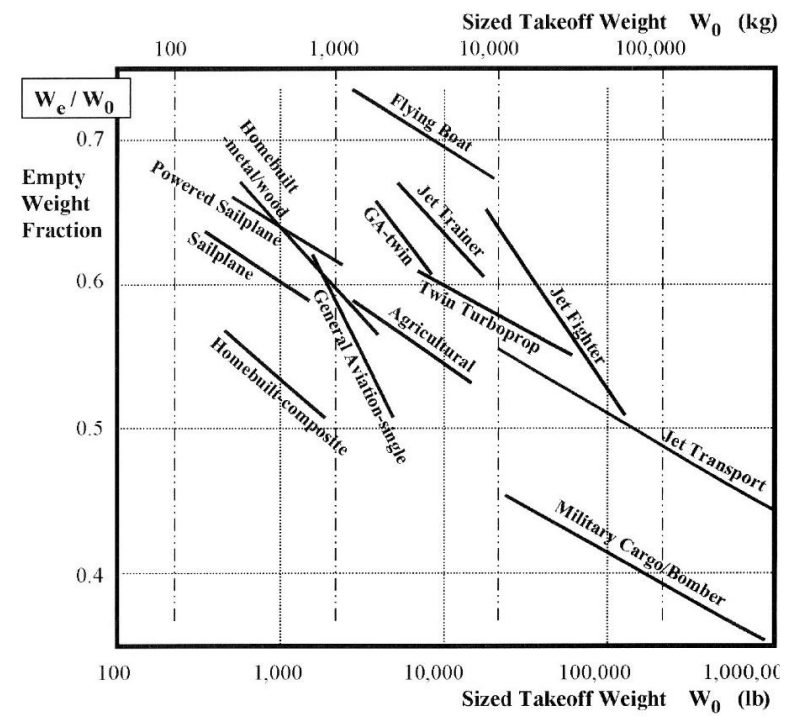

To estimate an empty weight fraction without knowing out estimated Gross Takeoff Weight, we will have to guess a Gross Takeoff Weight, then evaluate the equation to get empty weight fraction. Using the estimated empty weight fraction, we can evaluate the equation for Gross takeoff weight. Iterate until Gross Takeoff Weight and Empty Weight Fraction converge.

Source: Raymer 6th Ed. Chapter 3

In [90]:
#Inputs
coeff_A = .93  # primary coefficient for empty weight fraction estimate
exp_C = -.06  # exponent for empty weight fraction estimate
coeff_K_vs = 1.0  # variable sweep coefficient for empty weight fraction estimate

W_0_initial_guess = 3 * gravity  # N, initial guess for gross takeoff weight
convergence_threshold = 1e-3  # threshold for empty weight fraction and gross takeoff weight convergence


#Outputs

iter=0
converged=False
W_0 = W_0_initial_guess
EWF = coeff_A * (W_0**exp_C) * coeff_K_vs

while not converged:
    prev_W_0 = W_0
    prev_EWF = EWF

    EWF = coeff_A * (W_0**exp_C) * coeff_K_vs
    W_0 = W_payload / (1 - BMF - EWF)
    
    percent_change_W_0 = abs((W_0 - prev_W_0) / prev_W_0)
    percent_change_EWF = abs((W_0 - prev_EWF) / prev_EWF)

    if percent_change_EWF and percent_change_W_0 < convergence_threshold:
        converged = True

    iter+=1

    print(f"\nIteration: {iter}")
    print(f"Empty Weight Fraction: {EWF:.3f}")
    print(f"Gross Takeoff Weight: {W_0:.3f} N")


Iteration: 1
Empty Weight Fraction: 0.759
Gross Takeoff Weight: 30.789 N

Iteration: 2
Empty Weight Fraction: 0.757
Gross Takeoff Weight: 30.394 N

Iteration: 3
Empty Weight Fraction: 0.758
Gross Takeoff Weight: 30.505 N

Iteration: 4
Empty Weight Fraction: 0.758
Gross Takeoff Weight: 30.474 N

Iteration: 5
Empty Weight Fraction: 0.758
Gross Takeoff Weight: 30.483 N


### Final Results

In [91]:
print("Requirements:")
print(f"\tRange: {range/1000:.1f} km ({range/1000*km_to_mi:.1f} mi)")
print(f"\tPaload Mass: {W_payload/gravity:.3f} kg ({W_payload/gravity*kg_to_lbm:.3f} lbm)")

print("\nResults:")
print(f"\tEmpty Mass: {W_0*EWF/gravity:.3f} kg ({W_0*EWF/gravity*kg_to_lbm:.3f} lbm)")
print(f"\tBattery Mass: {W_0*BMF/gravity:.3f} kg ({W_0*BMF/gravity*kg_to_lbm:.3f} lbm)")
print(f"\tGross Takeoff Mass: {W_0/gravity:.3f} kg ({W_0/gravity*kg_to_lbm:.3f} lbm)")

Requirements:
	Range: 20.0 km (12.4 mi)
	Paload Mass: 0.500 kg (1.102 lbm)

Results:
	Empty Mass: 2.355 kg (5.192 lbm)
	Battery Mass: 0.253 kg (0.559 lbm)
	Gross Takeoff Mass: 3.108 kg (6.853 lbm)
